In [1]:
import batoid
import galsim
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

In [2]:
# Load optics definitions

lsst = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'LSST', 'LSST_r.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('LSST.LSSTCamera', [0,0,1e-3])

hsc = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'HSC', 'HSC.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('SubaruHSC.HSC', [0,0,900e-6])

decam = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'DECam', 'DECam.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('BlancoDECam.DECam', [0,0,1.5e-3])

In [27]:
def psfModelComparison(telescope, theta_x, theta_y, wavelength,
                       nx=64, pad_factor=4, h_factor=8,
                       title=None):
    
    # Non-paraxial optics FFT PSF
    npFFTPSF = batoid.fftPSF(telescope, theta_x, theta_y, wavelength, 
                             nx=nx, pad_factor=pad_factor)

    # Huygens PSF, using the same grid as for npFFT
    nxOut = nx*pad_factor//h_factor
    hPSF = batoid.huygensPSF(
        telescope, theta_x, theta_y, wavelength,
        nx=nx, nxOut=nxOut,
        dx=npFFTPSF.primitiveVectors[0]*h_factor,
        dy=npFFTPSF.primitiveVectors[1]*h_factor
    )
    print(npFFTPSF.primitiveVectors*h_factor)
    scale = np.sqrt(np.abs(np.linalg.det(h_factor*npFFTPSF.primitiveVectors.astype(float))))
    scale *= 1e6 # meters -> microns
#     extent = np.r_[-1,1,-1,1]*0.5*nxOut*scale
    extent_x = np.r_[-1,1]*0.5*nxOut*np.abs(hPSF.primitiveVectors[0][0])
    extent_y = np.r_[-1,1]*0.5*nxOut*np.abs(hPSF.primitiveVectors[1][1])
    extent = np.concatenate([extent_x, extent_y])
    extent *= 1e6 # meters -> microns
    print(extent)

    fig, axes = plt.subplots(ncols=3, figsize=(9.5, 2.5))
    im1 = axes[0].imshow(npFFTPSF.array[::h_factor, ::h_factor], extent=extent)
    plt.colorbar(im1, ax=axes[0])
    im2 = axes[1].imshow(hPSF.array, extent=extent)
    plt.colorbar(im2, ax=axes[1])
    im3 = axes[2].imshow(npFFTPSF.array[::h_factor, ::h_factor] - hPSF.array, extent=extent)
    plt.colorbar(im3, ax=axes[2])

    if title:
        fig.suptitle(title)
    
    axes[0].set_title("FFT Donut")
    axes[1].set_title("Huygens Donut")
    axes[2].set_title("Residual")
    for ax in axes:
        ax.set_xlabel("microns")
        ax.set_ylabel("microns")
    
    fig.tight_layout(pad=2.0, w_pad=0.4)
    fig.show()

[[ -2.37077329e-05   2.72531410e-21]
 [  0.00000000e+00  -2.37487067e-05]]
[-568.98558949  568.98558949 -569.9689601   569.9689601 ]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


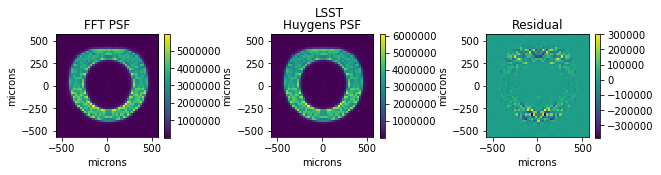

In [31]:
psfModelComparison(lsst, np.deg2rad(0.0), np.deg2rad(1.75), 600e-9, nx=1536, pad_factor=1, h_factor=32,
                   title="LSST")

[[ -1.10742915e-05   4.17953637e-12]
 [ -4.04341456e-11  -1.18922828e-05]]
[-531.56599008  531.56599008 -570.82957635  570.82957635]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


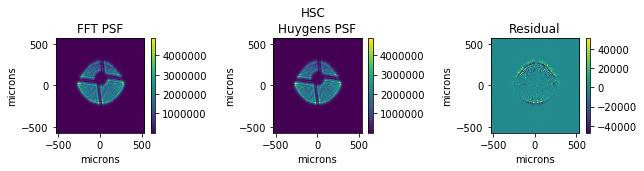

In [32]:
psfModelComparison(hsc, np.deg2rad(0.0), np.deg2rad(0.74), 600e-9, nx=768, pad_factor=1, h_factor=8,
                   title="HSC")

[[ -7.41845179e-06   1.58620324e-21]
 [ -8.53266307e-21  -7.42339945e-06]]
[-474.78091459  474.78091459 -475.09756484  475.09756484]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


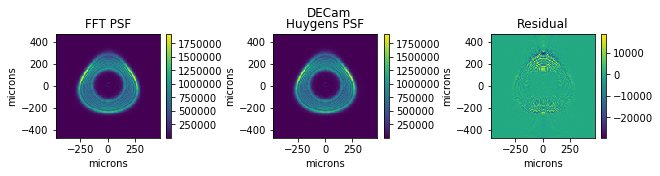

In [33]:
psfModelComparison(decam, np.deg2rad(0.0), np.deg2rad(1.1), 600e-9, nx=512, pad_factor=1, h_factor=4,
                   title="DECam")